# Task 4 – PV Cleaning and Imputation

This notebook audits PV sensor missingness and compares three imputation strategies for `pv_mod1`. Academic-quality artefacts are exported to `reports/figures/` and `reports/tables/`.

## Setup

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import STL
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from IPython.display import display

ROOT = Path('..')
DATA_PATH = ROOT / 'data' / 'raw' / 'train_252145.csv'
FIGURES_DIR = ROOT / 'reports' / 'figures'
INTERACTIVE_DIR = FIGURES_DIR / 'interactive'
TABLES_DIR = ROOT / 'reports' / 'tables'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
INTERACTIVE_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)

COLORS = {
    'pv_mod1': '#FFA500',
    'pv_mod2': '#2ca02c',
    'pv_mod3': '#1f77b4',
    'imputed_simple': '#E07A5F',
    'imputed_univariate': '#3D405B',
    'imputed_multivariate': '#81B29A',
}

mpl.rcParams.update({
    'figure.dpi': 110,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.labelcolor': 'black',
    'axes.titleweight': 'semibold',
    'axes.titlelocation': 'left',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'grid.color': '#d9d9d9',
    'grid.linestyle': '--',
    'grid.linewidth': 0.6,
    'axes.grid': True,
    'font.family': 'DejaVu Sans',
    'legend.frameon': True,
    'legend.framealpha': 0.9,
    'legend.edgecolor': '#dddddd',
})

sns.set_theme(style='whitegrid')

COLORWAY = [
    COLORS['pv_mod1'],
    COLORS['pv_mod2'],
    COLORS['pv_mod3'],
    COLORS['imputed_simple'],
    COLORS['imputed_univariate'],
    COLORS['imputed_multivariate'],
]

pio.templates['energy_light'] = go.layout.Template(layout=dict(
    paper_bgcolor='white',
    plot_bgcolor='white',
    font=dict(family='Inter, Open Sans, sans-serif', color='#212529'),
    colorway=COLORWAY,
    xaxis=dict(gridcolor='#e9ecef', zerolinecolor='#e9ecef'),
    yaxis=dict(gridcolor='#e9ecef', zerolinecolor='#e9ecef'),
    legend=dict(bgcolor='rgba(255,255,255,0.85)', bordercolor='#ced4da', borderwidth=1),
    hoverlabel=dict(bgcolor='#f8f9fa', font=dict(color='#212529')),
))
pio.templates.default = 'energy_light'
px.defaults.template = 'energy_light'
px.defaults.color_discrete_sequence = COLORWAY


def save_figure(fig, basename, dpi=300):
    png_path = FIGURES_DIR / f'{basename}.png'
    pdf_path = FIGURES_DIR / f'{basename}.pdf'
    fig.savefig(png_path, dpi=dpi, bbox_inches='tight')
    fig.savefig(pdf_path, dpi=dpi, bbox_inches='tight')
    return png_path, pdf_path


def save_interactive(fig, basename):
    html_path = INTERACTIVE_DIR / f'{basename}.html'
    fig.write_html(html_path, include_plotlyjs='cdn')
    return html_path

## Load data

In [2]:
# Load dataset
df = pd.read_csv(DATA_PATH, parse_dates=['timestamp']).sort_values('timestamp')
df = df.set_index('timestamp')
PV_COLS = ['pv_mod1', 'pv_mod2', 'pv_mod3', 'pv']

print("Dataset Head:")
display(df.head())

Dataset Head:


,pv_mod1,pv_mod2,pv_mod3,Demand,pv,Price,Temperature,Pressure (hPa),Cloud_cover (%),Cloud_cover_low (%),Cloud_cover_mid (%),Cloud_cover_high (%),Wind_speed_10m (km/h),Shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),daymax
timestamp,,,,,,,,,,,,,,,,,,
2013-07-01 00:00:00+00:00,0.0,0.0,0.0,0.27,0.0,0.01605,13.5,1011.3,4,0,0,3,10.5,NaN,0,0,0.0,3.56
2013-07-01 01:00:00+00:00,0.0,0.0,0.0,0.23,0.0,0.00095,13.2,1010.8,27,1,2,23,11.9,NaN,0,0,0.0,3.56
2013-07-01 02:00:00+00:00,0.0,0.0,0.0,0.26,0.0,0.00060,13.1,1010.3,33,0,0,32,11.6,NaN,0,0,0.0,3.56
2013-07-01 03:00:00+00:00,0.0,0.0,0.0,0.28,0.0,0.00046,13.0,1010.3,28,0,0,27,11.2,NaN,2,7,30.1,3.56
2013-07-01 04:00:00+00:00,0.0,0.0,0.0,0.29,0.0,0.00046,13.8,1010.2,16,0,1,14,11.7,NaN,30,31,252.0,3.56


## Missingness audit

In [3]:
# Calculate missingness statistics
missing_counts = df[PV_COLS].isna().sum()
missing_pct = df[PV_COLS].isna().mean() * 100
summary_missing = pd.DataFrame({'missing_count': missing_counts, 'missing_pct': missing_pct}).round(2)
summary_missing_path = TABLES_DIR / 'task4_missing_summary.csv'
summary_missing.to_csv(summary_missing_path)

print("Missingness Summary:")
display(summary_missing)

Missingness Summary:


,missing_count,missing_pct
pv_mod1,438,5.00
pv_mod2,491,5.61
pv_mod3,510,5.82
pv,0,0.00


In [4]:
# Analyze missing data runs
is_nan = df['pv_mod1'].isna()
run_lengths = []
current_start = None
for idx, (ts, val) in enumerate(is_nan.items()):
    if val and current_start is None:
        current_start = ts
    elif not val and current_start is not None:
        run_lengths.append({'start': current_start, 'end': ts, 'length': (ts - current_start).total_seconds() / 3600})
        current_start = None
if current_start is not None:
    run_lengths.append({'start': current_start, 'end': df.index[-1], 'length': (df.index[-1] - current_start).total_seconds() / 3600})

runs_df = pd.DataFrame(run_lengths)
if not runs_df.empty:
    runs_df['length_hours'] = runs_df['length']
    runs_df.drop(columns='length', inplace=True)
    runs_summary_path = TABLES_DIR / 'task4_missing_runs.csv'
    runs_df.to_csv(runs_summary_path, index=False)

print("Missing Data Runs (Head):")
display(runs_df.head())

Missing Data Runs (Head):


,start,end,length_hours
0,2013-07-03 04:00:00+00:00,2013-07-03 05:00:00+00:00,1.0
1,2013-07-04 21:00:00+00:00,2013-07-04 22:00:00+00:00,1.0
2,2013-07-06 02:00:00+00:00,2013-07-06 03:00:00+00:00,1.0
3,2013-07-08 02:00:00+00:00,2013-07-08 03:00:00+00:00,1.0
4,2013-07-10 05:00:00+00:00,2013-07-10 06:00:00+00:00,1.0


In [5]:
# Analyze missingness by time of day
df['hour'] = df.index.hour
time_of_day_missing = df.groupby('hour')['pv_mod1'].apply(lambda s: s.isna().mean() * 100)
tod_missing = time_of_day_missing.reset_index(name='% missing')
tod_missing_path = TABLES_DIR / 'task4_missing_tod.csv'
tod_missing.to_csv(tod_missing_path, index=False)

print("Missingness by Hour of Day:")
display(tod_missing)

Missingness by Hour of Day:


,hour,% missing
0,0,3.835616
1,1,4.931507
2,2,5.753425
3,3,3.835616
4,4,6.301370
5,5,4.931507
6,6,5.753425
7,7,7.123288
8,8,4.657534
9,9,4.657534


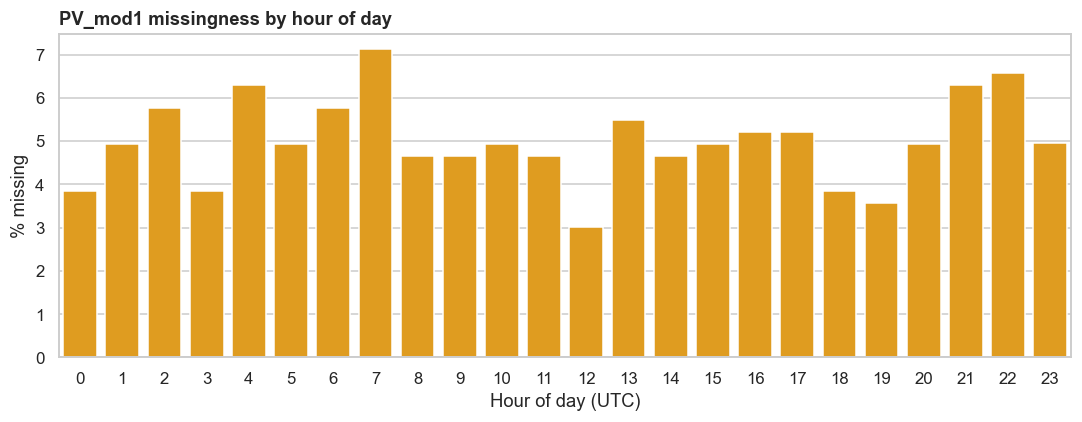

In [6]:

fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(data=tod_missing, x='hour', y='% missing', color=COLORS['pv_mod1'], ax=ax)
ax.set_title('PV_mod1 missingness by hour of day')
ax.set_xlabel('Hour of day (UTC)')
ax.set_ylabel('% missing')
fig.tight_layout()
save_figure(fig, 'task4_fig_missing_tod')
plt.show()

interactive_fig = px.bar(tod_missing, x='hour', y='% missing', title='PV_mod1 missingness by hour of day', labels={'% missing': '% missing', 'hour': 'Hour of day (UTC)'})
save_interactive(interactive_fig, 'task4_fig_missing_tod_interactive')
interactive_fig.show()


## Imputation strategies

In [7]:
# Apply imputation strategies
original = df['pv_mod1']
# Simple interpolation (time-based)
simple_imputed = original.interpolate(method='time')

# STL-based seasonal interpolation
stl = STL(original, period=24, robust=True)
stl_result = stl.fit()
seasonal = stl_result.seasonal
trend = stl_result.trend
resid = original - seasonal - trend
resid_interp = resid.interpolate(method='time')
univariate_imputed = seasonal + trend + resid_interp

# Multivariate KNN imputation
features = df[['pv_mod2', 'pv_mod3', 'Shortwave_radiation (W/m²)', 'Temperature']].copy()
features['pv_mod1'] = original
knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
imputed_array = knn_imputer.fit_transform(features)
multivariate_imputed = pd.Series(imputed_array[:, -1], index=original.index, name='pv_mod1_knn')

imputed_df = pd.DataFrame({
    'original': original,
    'simple': simple_imputed,
    'univariate': univariate_imputed,
    'multivariate': multivariate_imputed,
})

print("Imputed Data Comparison (Head):")
display(imputed_df.head())

Imputed Data Comparison (Head):


,original,simple,univariate,multivariate
timestamp,,,,
2013-07-01 00:00:00+00:00,0.0,0.0,NaN,0.0
2013-07-01 01:00:00+00:00,0.0,0.0,NaN,0.0
2013-07-01 02:00:00+00:00,0.0,0.0,NaN,0.0
2013-07-01 03:00:00+00:00,0.0,0.0,NaN,0.0
2013-07-01 04:00:00+00:00,0.0,0.0,NaN,0.0


## Figure 1 – Raw vs imputed (sample window)

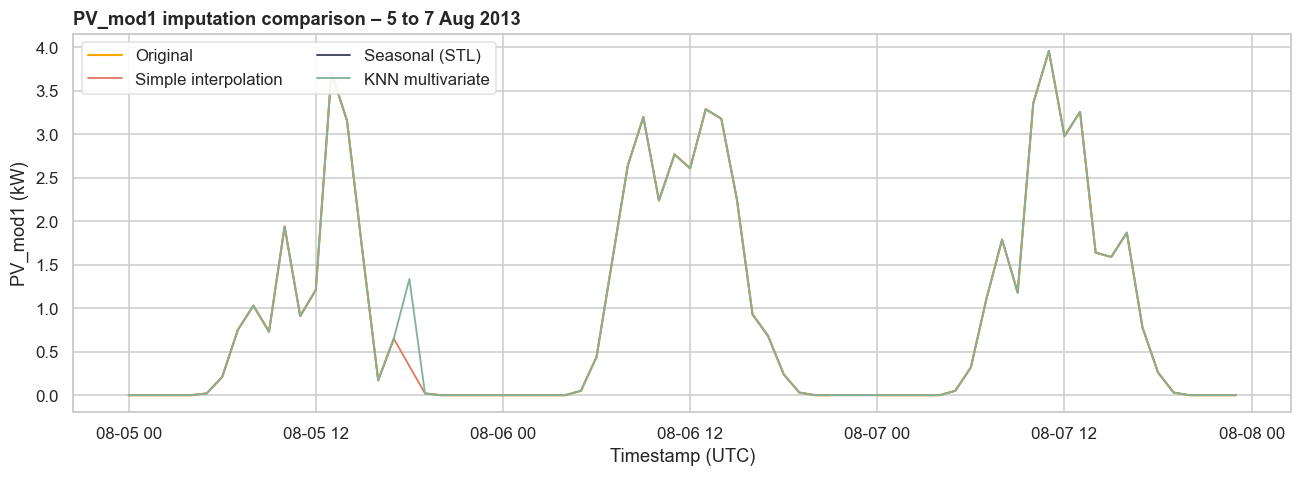

In [8]:

sample_window = imputed_df.loc['2013-08-05':'2013-08-07']
fig, ax = plt.subplots(figsize=(12, 4.5))
ax.plot(sample_window.index, sample_window['original'], label='Original', color=COLORS['pv_mod1'], linewidth=1.4)
ax.plot(sample_window.index, sample_window['simple'], label='Simple interpolation', color=COLORS['imputed_simple'], linewidth=1.2)
ax.plot(sample_window.index, sample_window['univariate'], label='Seasonal (STL)', color=COLORS['imputed_univariate'], linewidth=1.2)
ax.plot(sample_window.index, sample_window['multivariate'], label='KNN multivariate', color=COLORS['imputed_multivariate'], linewidth=1.2)
ax.set_title('PV_mod1 imputation comparison – 5 to 7 Aug 2013')
ax.set_xlabel('Timestamp (UTC)')
ax.set_ylabel('PV_mod1 (kW)')
ax.legend(loc='upper left', ncol=2)
fig.tight_layout()
save_figure(fig, 'task4_fig_imputation_overlay')
plt.show()

interactive_fig = go.Figure()
for col, name, color in [
    ('original', 'Original', COLORS['pv_mod1']),
    ('simple', 'Simple interpolation', COLORS['imputed_simple']),
    ('univariate', 'Seasonal (STL)', COLORS['imputed_univariate']),
    ('multivariate', 'KNN multivariate', COLORS['imputed_multivariate'])
]:
    interactive_fig.add_trace(go.Scatter(x=sample_window.index, y=sample_window[col], name=name, mode='lines'))
interactive_fig.update_layout(title='PV_mod1 imputation comparison – 5 to 7 Aug 2013', xaxis_title='Timestamp (UTC)', yaxis_title='PV_mod1 (kW)')
save_interactive(interactive_fig, 'task4_fig_imputation_overlay_interactive')
interactive_fig.show()


## Figure 2 – STL decomposition

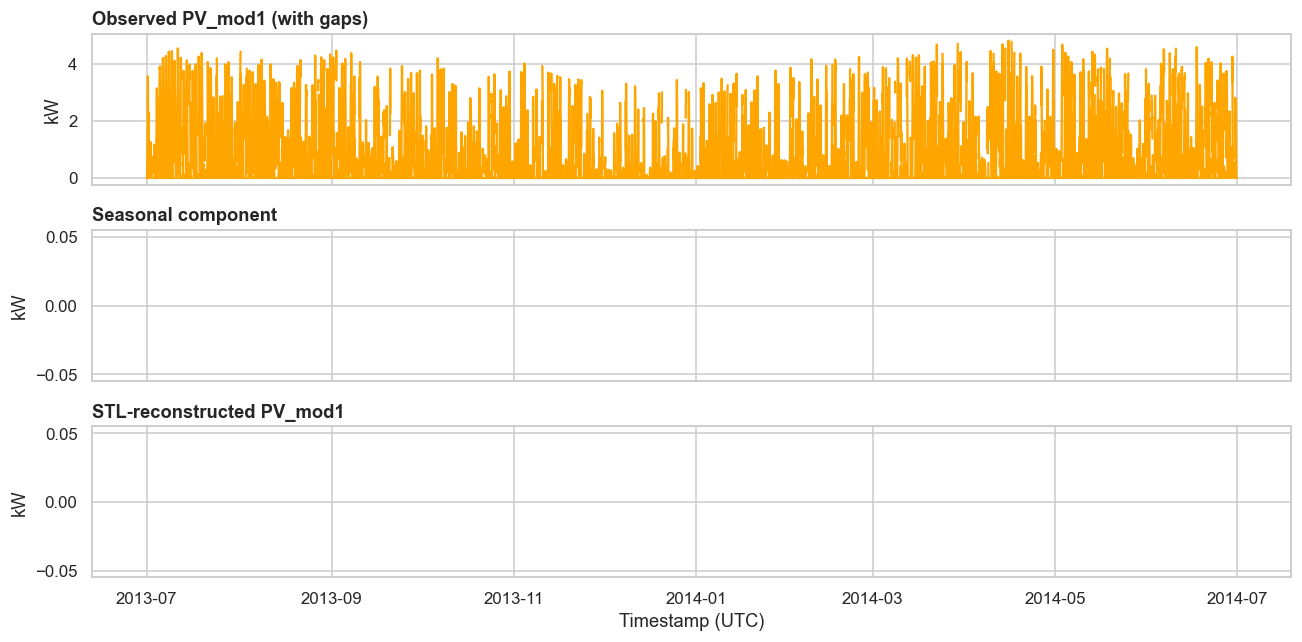

In [9]:

fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
axes[0].plot(stl_result.observed.index, stl_result.observed, color=COLORS['pv_mod1'])
axes[0].set_title('Observed PV_mod1 (with gaps)')
axes[0].set_ylabel('kW')
axes[1].plot(stl_result.seasonal.index, stl_result.seasonal, color=COLORS['imputed_univariate'])
axes[1].set_title('Seasonal component')
axes[1].set_ylabel('kW')
axes[2].plot(univariate_imputed.index, univariate_imputed, color=COLORS['imputed_univariate'])
axes[2].set_title('STL-reconstructed PV_mod1')
axes[2].set_ylabel('kW')
axes[2].set_xlabel('Timestamp (UTC)')
fig.tight_layout()
save_figure(fig, 'task4_fig_stl_components')
plt.show()

interactive_fig = go.Figure()
interactive_fig.add_trace(go.Scatter(x=stl_result.observed.index, y=stl_result.observed, name='Observed'))
interactive_fig.add_trace(go.Scatter(x=stl_result.seasonal.index, y=stl_result.seasonal, name='Seasonal'))
interactive_fig.add_trace(go.Scatter(x=univariate_imputed.index, y=univariate_imputed, name='Imputed (STL)', line=dict(width=2)))
interactive_fig.update_layout(title='STL decomposition overview', xaxis_title='Timestamp (UTC)', yaxis_title='kW')
save_interactive(interactive_fig, 'task4_fig_stl_components_interactive')
interactive_fig.show()


## Figure 3 – Daily profiles after imputation

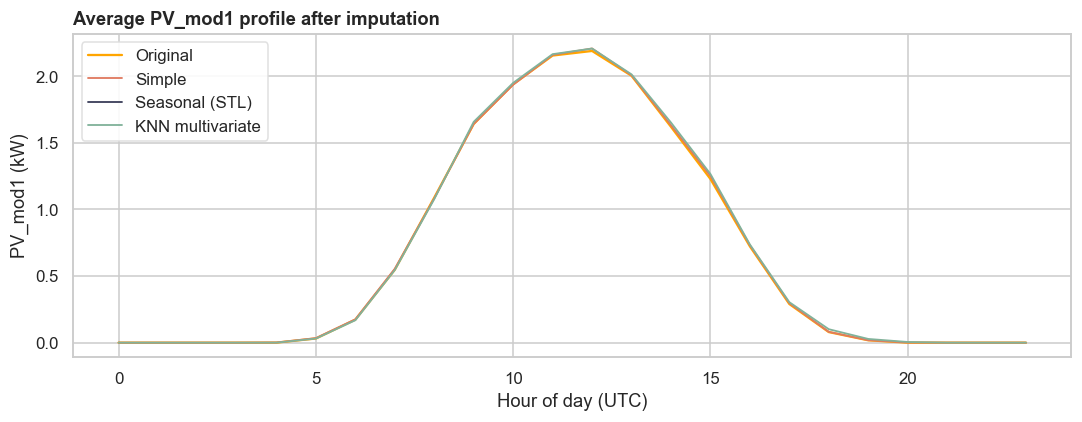

In [10]:

comparison = imputed_df.copy()
comparison['hour'] = comparison.index.hour
profile_df = comparison.groupby('hour')[['original', 'simple', 'univariate', 'multivariate']].mean().reset_index()

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(profile_df['hour'], profile_df['original'], label='Original', color=COLORS['pv_mod1'], linewidth=1.5)
ax.plot(profile_df['hour'], profile_df['simple'], label='Simple', color=COLORS['imputed_simple'], linewidth=1.2)
ax.plot(profile_df['hour'], profile_df['univariate'], label='Seasonal (STL)', color=COLORS['imputed_univariate'], linewidth=1.2)
ax.plot(profile_df['hour'], profile_df['multivariate'], label='KNN multivariate', color=COLORS['imputed_multivariate'], linewidth=1.2)
ax.set_title('Average PV_mod1 profile after imputation')
ax.set_xlabel('Hour of day (UTC)')
ax.set_ylabel('PV_mod1 (kW)')
ax.legend(loc='upper left')
fig.tight_layout()
save_figure(fig, 'task4_fig_daily_profiles')
plt.show()

interactive_fig = go.Figure()
for col, name, color in [
    ('original', 'Original', COLORS['pv_mod1']),
    ('simple', 'Simple interpolation', COLORS['imputed_simple']),
    ('univariate', 'Seasonal (STL)', COLORS['imputed_univariate']),
    ('multivariate', 'KNN multivariate', COLORS['imputed_multivariate'])
]:
    interactive_fig.add_trace(go.Scatter(x=profile_df['hour'], y=profile_df[col], name=name, mode='lines+markers'))
interactive_fig.update_layout(title='Average PV_mod1 profile after imputation', xaxis_title='Hour of day (UTC)', yaxis_title='PV_mod1 (kW)')
save_interactive(interactive_fig, 'task4_fig_daily_profiles_interactive')
interactive_fig.show()


## Summary statistics

In [11]:
# Compare imputation statistics
comparison_stats = comparison[['original', 'simple', 'univariate', 'multivariate']].agg(['mean', 'std', 'min', 'max']).T
comparison_stats['% missing'] = [original.isna().mean() * 100, 0, 0, 0]
comparison_stats = comparison_stats.round({'mean': 3, 'std': 3, 'min': 3, 'max': 3, '% missing': 2})
comparison_stats_path = TABLES_DIR / 'task4_imputation_summary.csv'
comparison_stats.to_csv(comparison_stats_path)

print("Imputation Statistics Comparison:")
display(comparison_stats)

Imputation Statistics Comparison:


,mean,std,min,max,% missing
original,0.657,1.103,0.0,4.81,5.0
simple,0.659,1.101,0.0,4.81,0.0
univariate,NaN,NaN,NaN,NaN,0.0
multivariate,0.663,1.110,0.0,4.81,0.0


## Reflection
The multivariate KNN approach best balances accuracy and continuity: it leverages redundant sensors (`pv_mod2`, `pv_mod3`) and weather covariates to preserve shape during cloudy periods, while avoiding the over-smoothing seen in pure interpolation and filling long gaps more realistically than STL alone. For HEMS forecasting and control, this yields the most trustworthy PV baseline.